In [1]:
from __future__ import annotations


import argparse
import pickle
#import tikzplotlib
import re
from tqdm import tqdm
from collections import Counter
from copy import copy
from dataclasses import dataclass
from functools import partial
from itertools import chain, product
from pathlib import Path
from typing import Callable, Iterable, Sequence, Optional, Tuple

import colorcet as cc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
import networkx


import tabpfn.scripts.tabular_baselines as tb
from tabpfn.datasets import load_openml_list, open_cc_dids, open_cc_valid_dids
from tabpfn.scripts.tabular_baselines import clf_dict
from tabpfn.scripts.tabular_evaluation import check_file_exists, evaluate, get_scoring_string
from tabpfn.scripts.tabular_metrics import (accuracy_metric, auc_metric,
                                            brier_score_metric,
                                            calculate_score, cross_entropy,
                                            ece_metric, time_metric)
from tabpfn.utils import torch_nanmean

from IPython.display import Image


In [2]:
HERE = Path(".").resolve().absolute()

METRICS = {
    "roc": auc_metric,
    "cross_entropy": cross_entropy,
    "acc": accuracy_metric,
    "brier_score": brier_score_metric,
    "ece": ece_metric,
}

PREDEFINED_RESULTS_PATH = HERE / "TabPFNRawResultsHourSearch"

PREDFINED_DATASET_PATHS = HERE / "tabpfn" / "datasets"
PREDEFINED_DATASET_COLLECTIONS = {
    "cc_valid": {
        "ids": open_cc_valid_dids,
        "path": PREDFINED_DATASET_PATHS / "cc_valid_datasets_multiclass.pickle",
    },
    "cc_test": {
        "ids": open_cc_dids,
        "path": PREDFINED_DATASET_PATHS / "cc_test_datasets_multiclass.pickle",
    },
}


LABEL_NAMES = {
    "transformer": "TabPFN",
    "transformer_gpu_N_1": "TabPFN GPU (N_ens =  1)",
    "transformer_gpu_N_4": "TabPFN GPU (N_ens =  4)",
    "transformer_gpu_N_8": "TabPFN GPU (N_ens =  8)",
    "transformer_gpu_N_32": "TabPFN GPU (N_ens = 32)",
    "transformer_cpu_N_1": "TabPFN CPU (N_ens =  1)",
    "transformer_cpu_N_4": "TabPFN CPU (N_ens =  4)",
    "transformer_cpu_N_8": "TabPFN CPU (N_ens =  8)",
    "transformer_cpu_N_32": "TabPFN CPU (N_ens = 32)",
    "autogluon": "Autogluon",
    "autosklearn2": "Autosklearn2",
    "gp_default": "default GP (RBF)",
    "gradient_boosting": "tuned Grad. Boost.",
    "gradient_boosting_default": "default Grad. Boost.",
    "lightgbm": "tuned LGBM",
    "lightgbm_default": "default LGBM",
    "gp": "tuned GP (RBF)",
    "logistic": "tuned Log. Regr.",
    "knn": "tuned KNN",
    "catboost": "tuned Catboost",
    "catboost_default": "default Catboost",
    "xgb": "tuned XGB",
    "xgb_default": "default XGB",
    # "catboost_gpu": "tuned Catboost (GPU)",
    # "catboost_default_gpu": "default Catboost (GPU)",
    # "xgb_gpu": "tuned XGB (GPU)",
    # "xgb_default_gpu": "default XGB (GPU)",
    "svm": "tuned SVM",
    "svm_default": "default SVM",
    "random_forest": "tuned Random Forest",
    "rf_default_n_estimators_10": "default Rand. Forest (N_est =  10)",
    "rf_default_n_estimators_32": "default Rand. Forest (N_est =  32)",
    "rf_default": "default Rand. Forest (N_est = 100)",
    "autogluon": "AutoGluon",
    "autosklearn": "AutoSklearn",
    "autosklearn2": "AutoSklearn2",
    "autopytorch": "Reg. Cocktails",
    # "naiveautoml": "Naive AutoML",
    "naiveautoml_iter_10": "Naive AutoML (max_hpo_iterations=10)"
}
FAMILY_NAMES = {
    "gp": "GP",
    "knn": "KNN",
    "lightgbm": "LGBM",
    "logistic": "Log. Regr.",
    "rf": "RF",
    "svm": "SVM",
    "transformer_cpu": "TabPFN CPU",
    "transformer_gpu": "TabPFN GPU",
    "xgb": "XGB",
    "xgb_gpu": "XGB GPU",
    "catboost": "CatBoost",
    "catboost_gpu": "CatBoost GPU",
    "autogluon": "AutoGluon",
    # "autosklearn": "AutoSklearn",
    "autosklearn2": "AutoSklearn2",
    "gradient_boosting": "GB",
    "naiveautoml": "Naive AutoML",
    "autopytorch": "Reg. Cocktails",
}


TUNED_METHOD_SUBSET = ["transformer_gpu_N_32"]#, "autosklearn2", "xgb", "svm", "gp", "lightgbm", "random_forest", "xgb_default"]
DEFAULT_METHOD_SUBSET = ["transformer_gpu_N_1"]#, "lightgbm_default", "xgb_default", "svm_default", "gp_default", "rf_default"]

TUNED_ENSEMBLE_METHODS = [
    'ensembletransformer_gpu_N_32autosklearn2',
    'ensembletransformer_gpu_N_32gp',
    'ensembletransformer_gpu_N_32lightgbm',
    'ensembletransformer_gpu_N_32svm',
    'ensembletransformer_gpu_N_32xgb',
    'ensembletransformer_gpu_N_32xgb_default',
    'ensembletransformer_gpu_N_32random_forest',
    "ensembletransformer_gpu_N_32autogluon"
]

DEFAULT_ENSEMBLE_METHODS = [
    'ensembletransformer_gpu_N_1gp_default',
    'ensembletransformer_gpu_N_1lightgbm_default',
    'ensembletransformer_gpu_N_1svm_default',
    'ensembletransformer_gpu_N_1xgb_default',
    'ensembletransformer_gpu_N_1rf_default'
]

ENSEMBLE_LABEL_NAMES = {
    "ensembletransformer_gpu_N_32autosklearn2": "TabPFN GPU (N_ens =  32) + AutoSklearn2",
    "ensembletransformer_gpu_N_32gp": "TabPFN GPU (N_ens =  32) + tuned GP",
    "ensembletransformer_gpu_N_32lightgbm": "TabPFN GPU (N_ens =  32) + tuned LightGBM",
    "ensembletransformer_gpu_N_32svm": "TabPFN GPU (N_ens =  32) + tuned SVM",
    "ensembletransformer_gpu_N_32xgb": "TabPFN GPU (N_ens =  32) + tuned XGB",
    "ensembletransformer_gpu_N_32xgb_default": "TabPFN GPU (N_ens =  32) + default XGB",
    "ensembletransformer_gpu_N_32random_forest": "TabPFN GPU (N_ens =  32) + tuned RF",
    "ensembletransformer_gpu_N_1gp_default": "TabPFN GPU (N_ens =  1) + default GP",
    "ensembletransformer_gpu_N_1lightgbm_default": "TabPFN GPU (N_ens =  1) + default LightGBM",
    "ensembletransformer_gpu_N_1svm_default": "TabPFN GPU (N_ens =  1) + default SVM",
    "ensembletransformer_gpu_N_1xgb_default": "TabPFN GPU (N_ens =  1) + default XGB",
    "ensembletransformer_gpu_N_1rf_default": "TabPFN GPU (N_ens =  1) + default RF",
    "ensembletransformer_gpu_N_32autogluon": "TabPFN GPU (N_ens =  32) + AutoGluon",
}

ENSEMBLE_FAMILY_NAMES = {
    "ensembletransformer_gpu": "Ensemble",
    "ensembletransformer_gpu_32xgb": "Ensemble XGB + TabPFN",
    "ensembletransformer_cpu": "Ensemble",

}

LABEL_NAMES = {**LABEL_NAMES, **ENSEMBLE_LABEL_NAMES}

FAMILY_NAMES = {**FAMILY_NAMES, **ENSEMBLE_FAMILY_NAMES}


TITLE_FONT_SIZE = 45
XLABEL_FONT_SIZE = 30
YLABEL_FONT_SIZE = 15

In [3]:
# Predefined methods with `no_tune={}` inidicating they are not tuned
METHODS = {
    # Transformers
    "transformer_cpu_N_1": partial(
        clf_dict["transformer"], device="cpu", N_ensemble_configurations=1
    ),
    "transformer_cpu_N_4": partial(
        clf_dict["transformer"], device="cpu", N_ensemble_configurations=4
    ),
    "transformer_cpu_N_8": partial(
        clf_dict["transformer"], device="cpu", N_ensemble_configurations=8
    ),
    "transformer_cpu_N_32": partial(
        clf_dict["transformer"], device="cpu", N_ensemble_configurations=32
    ),
    "transformer_gpu_N_1": partial(
        clf_dict["transformer"], device="cuda", N_ensemble_configurations=1
    ),
    "transformer_gpu_N_4": partial(
        clf_dict["transformer"], device="cuda", N_ensemble_configurations=4
    ),
    "transformer_gpu_N_8": partial(
        clf_dict["transformer"], device="cuda", N_ensemble_configurations=8
    ),
    "transformer_gpu_N_32": partial(
        clf_dict["transformer"], device="cuda", N_ensemble_configurations=32
    ),
}

In [4]:
@dataclass
class Dataset:
    """Small helper class just to name entries in the loaded pickled datasets."""

    name: str
    X: torch.Tensor
    y: torch.Tensor
    categorical_columns: list[int]
    attribute_names: list[str]
    # Seems to be some things about how the dataset was constructed
    info: dict
    # Only 'multiclass' is known?
    task_type: str

    @property
    def categorical(self) -> bool:
        return len(self.categorical_columns) == len(self.attribute_names)

    @property
    def numerical(self) -> bool:
        return len(self.categorical_columns) == 0

    @property
    def mixed(self) -> bool:
        return not self.numerical and not self.categorical

    @classmethod
    def fetch(
        self,
        identifier: str | int | list[int],
        only: Callable | None = None,
    ) -> list[Dataset]:
        if isinstance(identifier, str) and identifier in PREDEFINED_DATASET_COLLECTIONS:
            datasets = Dataset.from_predefined(identifier)
        elif isinstance(identifier, int):
            identifier = [identifier]
            datasets = Dataset.from_openml(identifier)
        elif isinstance(identifier, list):
            datasets = Dataset.from_openml(identifier)
        else:
            raise ValueError(identifier)

        if only:
            return list(filter(only, datasets))
        else:
            return datasets

    @classmethod
    def from_pickle(self, path: Path, task_types: str) -> list[Dataset]:
        with path.open("rb") as f:
            raw = pickle.load(f)

        return [Dataset(*entry, task_type=task_types) for entry in raw]  # type: ignore

    @classmethod
    def from_predefined(self, name: str) -> list[Dataset]:
        assert name in PREDEFINED_DATASET_COLLECTIONS
        path = PREDEFINED_DATASET_COLLECTIONS[name]["path"]

        return Dataset.from_pickle(path, task_types="multiclass")

    @classmethod
    def from_openml(
        self,
        dataset_id: int | list[int],
        filter_for_nan: bool = False,
        min_samples: int = 100,
        max_samples: int = 2_000,
        num_feats: int = 100,
        return_capped: bool = False,
        shuffled: bool = True,
        multiclass: bool = True,
    ) -> list[Dataset]:
        # TODO: should be parametrized, defaults taken from ipy notebook
        if not isinstance(dataset_id, list):
            dataset_id = [dataset_id]

        datasets, _ = load_openml_list(
            dataset_id,
            filter_for_nan=filter_for_nan,
            num_feats=num_feats,
            min_samples=min_samples,
            max_samples=max_samples,
            return_capped=return_capped,
            shuffled=shuffled,
            multiclass=multiclass,
        )
        return [
            Dataset(  # type: ignore
                *entry,
                task_type="multiclass" if multiclass else "binary",
            )
            for entry in datasets
        ]

    def as_list(self) -> list:
        """How the internals expect a dataset to look like."""
        return [
            self.name,
            self.X,
            self.y,
            self.categorical_columns,
            self.attribute_names,
            self.info,
        ]

In [5]:
@dataclass
class Results:
    # Big ass predefined dictionary
    df: pd.DataFrame

    @classmethod
    def from_dict(
        self,
        d: dict,
        datasets: list[Dataset],
        recorded_metrics: list[str],
        *,
        dropna: bool = True,
    ) -> Results:
        # TODO: we could extract dataset_names for the dict but it's not ordered well
        #   for that. Likewise for the recorded_metrics
        #
        # We do a lot of parsing here to massage things into a nice table
        # Extract all the times listed in the keys
        pattern = re.compile(
            r"(?P<method>\w+)"
            r"_time_(?P<time>\d+(\.\d+)?)"
            r"(_)?(?P<metric>\w+)"
            r"_split_(?P<split>\d+)"
        )

        groups = []
        for key in d:
            match = re.match(pattern, key)
            if not match:
                raise ValueError(key)

            groups.append(match.groupdict())

        matches = pd.DataFrame(groups)

        # The unique, methods, times, metrics and splits present
        methods = list(matches["method"].unique())
        times = list(matches["time"].astype(float).unique())
        metrics = list(matches["metric"].unique())
        splits = list(matches["split"].astype(int).unique())

        # Next we extract all the eval_positions
        _eval_positions = set()
        for v in d.values():
            _eval_positions.update(v["eval_positions"])
        eval_positions = sorted(_eval_positions)

        # Dataset names...
        dataset_names = sorted([d.name for d in datasets])

        # We flatten out the fit_time and inference_time of best_config
        for (k, v), pos, dataset in product(d.items(), eval_positions, datasets):
            old_best_configs_key = f"{dataset.name}_best_configs_at_{pos}"

            best_config_key = f"{dataset.name}_best_config"
            inference_time_key = f"{dataset.name}_inference_time_at_{pos}"
            fit_time_key = f"{dataset.name}_fit_time_at_{pos}"

            # If there is a best config
            if "transformer_gpu" not in k and "autosklearn" not in k and any(v.get(old_best_configs_key, [])):
                assert len(v[old_best_configs_key]) == 1

                best_config = v[old_best_configs_key][0]

                v[inference_time_key] = best_config.get("inference_time", np.nan)
                v[fit_time_key] = best_config.get("fit_time", np.nan)
                v[best_config_key] = best_config.copy()
                del v[old_best_configs_key]
            else:
                v[inference_time_key] = np.nan
                v[fit_time_key] = np.nan
                v[best_config_key] = np.nan

        index = pd.MultiIndex.from_product(
            [methods, metrics, times, eval_positions, splits],
            names=[
                "method",
                "optimization_metric",
                "optimization_time",
                "eval_position",
                "split",
            ],
        )

        metrics = recorded_metrics + ["inference_time", "fit_time"]
        if "time" not in metrics:
            metrics.append("time")

        columns = pd.MultiIndex.from_product(
            [metrics, dataset_names],
            names=["metric", "dataset"],
        )

        df = pd.DataFrame(columns=columns, index=index)
        df.sort_index(inplace=True)

        for k, v in d.items():
            match = re.match(pattern, k)
            if match is None:
                raise ValueError(k)

            method = match.group("method")
            time = float(match.group("time"))
            opt_metric = match.group("metric")
            split = int(match.group("split"))

            for dataset, metric, pos in product(dataset_names, metrics, eval_positions):
                row = (method, opt_metric, time, int(pos), split)
                col = (metric, dataset)

                value = v.get(f"{dataset}_{metric}_at_{pos}", np.nan)

                df.loc[row, col] = value

        # Drop full NaN rows
        if dropna:
            df = df[df.any(axis=1)]

        return Results(df)

    def at(
        self,
        *,
        method: str | list[str] | None = None,
        optimization_metric: str | list[str] | None = None,
        optimization_time: float | list[float] | None = None,
        split: int | list[int] | None = None,
        eval_position: int | list[int] | None = None,
        dataset: str | list[str] | None = None,
        metric: str | list[str] | None = None,
    ) -> Results:
        """Use this for slicing in to the dataframe to get what you need"""
        df = self.df
        items = {
            "method": method,
            "optimization_time": optimization_time,
            "optimization_metric": optimization_metric,
            "split": split,
            "eval_position": eval_position,
        }
        for name, item in items.items():
            if item is None:
                continue
            idx: list = item if isinstance(item, list) else [item]
            df = df[df.index.get_level_values(name).isin(idx)]
            if not isinstance(item, list):
                df = df.droplevel(name, axis="index")

        if dataset:
            _dataset = dataset if isinstance(dataset, list) else [dataset]
            df = df.T.loc[df.T.index.get_level_values("dataset").isin(_dataset)].T
            if not isinstance(dataset, list):
                df = df.droplevel("dataset", axis="columns")

        if metric:
            _metric = metric if isinstance(metric, list) else [metric]
            df = df.T.loc[df.T.index.get_level_values("metric").isin(_metric)].T
            if not isinstance(metric, list):
                df = df.droplevel("metric", axis="columns")

        return Results(df)

    @property
    def methods(self) -> list[str]:
        return list(self.df.index.get_level_values("method").unique())

    @property
    def optimization_metrics(self) -> list[str]:
        return list(self.df.index.get_level_values("optimization_metric").unique())

    @property
    def optimization_times(self) -> list[float]:
        return list(self.df.index.get_level_values("optimization_time").unique())

    @property
    def eval_positions(self) -> list[int]:
        return list(self.df.index.get_level_values("eval_position").unique())
    
    @property
    def splits(self) -> list[int]:
        return list(self.df.index.get_level_values("split").unique())

    @property
    def datasets(self) -> list[str]:
        return list(self.df.columns.get_level_values("dataset").unique())

    @property
    def metrics(self) -> list[str]:
        return list(self.df.columns.get_level_values("metric").unique())

In [6]:
def eval_method(
    datasets: list[Dataset],
    label: str,
    classifier_evaluator: Callable,
    max_time: float | None,
    metric_used: Callable,
    split: int,
    eval_positions: list[int],
    result_path: Path,
    append_metric: bool = True,
    fetch_only: bool = False,
    verbose: bool = False,
    bptt: int = 2000,
    overwrite: bool = False,
):
    """Evaluate a given method."""
    if max_time is not None:
        label += f"_time_{max_time}"

    if append_metric:
        label += f"_{tb.get_scoring_string(metric_used, usage='')}"

    if isinstance(classifier_evaluator, partial):
        device = classifier_evaluator.keywords.get("device", "cpu")
    else:
        device = "cpu"
    device = "cpu"

    task_type = "multiclass"
    if any(d.task_type != task_type for d in datasets):
        raise RuntimeError("Not sure how to handle this yet")

    return evaluate(
        datasets=[d.as_list() for d in datasets],
        model=classifier_evaluator,
        method=label,
        bptt=bptt,
        base_path=result_path,
        eval_positions=eval_positions,
        device=device,
        max_splits=1,
        overwrite=overwrite,
        save=True,
        metric_used=metric_used,
        path_interfix=task_type,
        fetch_only=fetch_only,
        split_id=split,
        verbose=verbose,
        max_time=max_time,
    )

def do_evaluations(args: argparse.Namespace, datasets: list[Dataset]) -> Results:
    results = {}
    for method, metric, time, split in product(
        args.methods,
        args.optimization_metrics,
        args.times,
        range(1, args.splits+1),
    ):
        metric_f = METRICS[metric]
        metric_name = tb.get_scoring_string(metric_f, usage="")
        key = f"{method}_time_{time}{metric_name}_split_{split}"

        results[key] = eval_method(
            datasets=datasets,
            label=method,
            result_path=args.result_path,
            classifier_evaluator=METHODS[method],
            eval_positions=args.eval_positions,  # It's a constant basically
            fetch_only=args.fetch_only,
            verbose=args.verbose,
            max_time=time,
            metric_used=metric_f,
            split=split,
            overwrite=args.overwrite,
        )

    datasets_as_list = [d.as_list() for d in datasets]

    # This will update the results in place
    for metric in args.recorded_metrics:
        metric_f = METRICS[metric]
        calculate_score(
            metric=metric_f,
            name=metric,
            global_results=results,
            ds=datasets_as_list,
            eval_positions=args.eval_positions,
        )

    # We also get the times
    calculate_score(
        metric=time_metric,
        name="time",
        global_results=results,
        ds=datasets_as_list,
        eval_positions=args.eval_positions,
    )

    return Results.from_dict(
        results,
        datasets=datasets,
        recorded_metrics=args.recorded_metrics + ["time"],
    )

"""
def do_cd_plot(
    result: Results,
    title_prefix: str,
    fig_name: str,
    path: Path,
    metric: str = "roc",
    figsize: tuple[int, int] = (12, 10),
    dpi: int = 120,
    extension: str = "png",
    eval_position: int = 1_000,
    shift_legend: bool = True,
    method: str | List[str] | None = None
) -> None:
    for opt_time, opt_metric in zip(
        result.optimization_times,
        result.optimization_metrics,
    ):
        fig, axes = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        Plotter(result).cd_plot(
            method=method,
            optimization_metric=opt_metric,
            optimization_time=opt_time,
            eval_position=eval_position,
            metric=metric,
            ax=axes,
        )
        axes.set_title(f"{title_prefix} [opt_time={opt_time}, opt_metric={opt_metric}]")

        # if shift_legend:
        #     sns.move_legend(axes, "upper left", bbox_to_anchor=(1, 1))

        stem = f"{fig_name}_opt_metric_{opt_metric}_opt_time_{opt_time}_metric_{metric}"
        if extension == 'tex':
          tikzplotlib.save(path / f"{stem}.{extension}")
        else:
          fig.savefig(path / f"{stem}.{extension}", bbox_inches="tight")
          # Image(path / f"{stem}.{extension}")
        #   fig.show()
    return axes, fig

def do_plot(
    result: Results,
    title_prefix: str,
    fig_name: str,
    path: Path,
    metric: str = "roc",
    figsize: tuple[int, int] = (12, 10),
    dpi: int = 120,
    extension: str = "png",
    eval_position: int = 1_000,
    shift_legend: bool = True,
    bottom_families: str | None = None,
    switch_colours_pairs: list[tuple[str]] | None = None
) -> None:
    for opt_time, opt_metric in zip(
        result.optimization_times,
        result.optimization_metrics,
    ):
        fig, axes = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        Plotter(result).overall_plot(
            optimization_metric=opt_metric,
            optimization_time=opt_time,
            eval_position=eval_position,
            metric=metric,
            ax=axes,
            bottom_families=bottom_families,
            switch_colours_pairs=switch_colours_pairs
        )
        axes.set_title(f"{title_prefix} [opt_time={opt_time}, opt_metric={opt_metric}]")

        if shift_legend:
            sns.move_legend(axes, "upper left", bbox_to_anchor=(1, 1))

        stem = f"{fig_name}_opt_metric_{opt_metric}_opt_time_{opt_time}_metric_{metric}"


        if extension == 'tex':
          tikzplotlib.save(path / f"{stem}.{extension}")
        else:
          fig.savefig(path / f"{stem}.{extension}", bbox_inches="tight")
          # Image(path / f"{stem}.{extension}")
          # fig.show()
    return axes, fig

import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__
""";

In [7]:
from argparse import Namespace

# For your own custom evaluation, please comment out the one from below
args = Namespace(
    result_path=HERE, # Where to store results - HERE/results
    gpu=False,  # Whether a GPU is accessible
    times=[3600], # How much optimization time is given to methods requiring it
    splits=1, # How many splits to run
    validation_datasets="cc_valid", # "cc_valid" or list of openml ids
    test_datasets="cc_test", # "cc_test" or list of openml ids
    optimization_metrics=["roc"], # ["roc", "cross_entropy", "acc", "brier_score", "ece"]m
    recorded_metrics=["roc", "cross_entropy", "acc", "brier_score", "ece"], # Same as above
    methods=["transformer_cpu_N_32"], # See keys of METHODS in Constants section
    fetch_only=False, # Will only fetch results and not compute anything
    bptt=2_000, # Transformer sequence length
    eval_positions=[1_000], # Leave as is
    overwrite=True, # Will overwrite results
    plot=False, # Do plots
    plot_directory=HERE/ "plots",  # Where to store plots
    figsize=(14, 10),  # The figure size for matplotlib
    dpi=140,  # The DPI for figures by matplotlib
    extension="pdf", # The extension for saving figures
    verbose=True,

    # Use this to use the predefined results from experiments
    # See the commented out block below
    load_predefined_results=False,
    predefined_results_path=PREDEFINED_RESULTS_PATH,
)

# We need to create some directories for this to work
(args.result_path / "results" / "tabular" / "multiclass").mkdir(
    parents=True, exist_ok=True
)
#""";

# We ignore the flags datasets
filter_f = lambda d: d.name != "flags"  # noqa: ignore

valid_datasets = Dataset.fetch("cc_valid", only=filter_f)
test_datasets = Dataset.fetch("cc_test", only=filter_f)

all_datasets = valid_datasets + test_datasets

dataset_collections = {
    "All Datasets": [d.name for d in all_datasets],
    "Categorical Datasets": [d.name for d in all_datasets if d.categorical or d.mixed],
    "Numerical Datasets": [d.name for d in all_datasets if d.numerical],
    "Validation Datasets": [d.name for d in valid_datasets],
    "Categorical Validation Datasets": [
        d.name for d in valid_datasets if d.categorical or d.mixed
    ],
    "Numerical Validation Datasets": [
        d.name for d in valid_datasets if d.numerical
    ],
    "Test Datasets": [d.name for d in test_datasets],
    "Categorical Test Datasets": [
        d.name for d in test_datasets if d.categorical or d.mixed
    ],
    "Numerical Test Datasets": [d.name for d in test_datasets if d.numerical],
}
result = do_evaluations(args, test_datasets)

Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 312:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([312, 4])  Test data shape torch.Size([312, 4])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 312:   0%| | 0/1 [00:18<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_balance-scale_312_624_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 1000:   0%| | 0/1 [00:00<?, ?it/

Train data shape torch.Size([1000, 76])  Test data shape torch.Size([1000, 76])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 1000:   0%| | 0/1 [01:26<?, ?it/
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_mfeat-fourier_1000_2000_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 349:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([349, 9])  Test data shape torch.Size([349, 9])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 349:   0%| | 0/1 [00:18<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_breast-w_349_698_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 1000:   0%| | 0/1 [00:00<?, ?it/

Train data shape torch.Size([1000, 64])  Test data shape torch.Size([1000, 64])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 1000:   0%| | 0/1 [01:23<?, ?it/
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_mfeat-karhunen_1000_2000_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 1000:   0%| | 0/1 [00:00<?, ?it/

Train data shape torch.Size([1000, 6])  Test data shape torch.Size([1000, 6])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 1000:   0%| | 0/1 [01:31<?, ?it/
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_mfeat-morphological_1000_2000_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 1000:   0%| | 0/1 [00:00<?, ?it/

Train data shape torch.Size([1000, 47])  Test data shape torch.Size([1000, 47])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 1000:   0%| | 0/1 [01:26<?, ?it/
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_mfeat-zernike_1000_2000_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 736:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([736, 9])  Test data shape torch.Size([736, 9])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 736:   0%| | 0/1 [00:54<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_cmc_736_1472_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 345:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([345, 15])  Test data shape torch.Size([345, 15])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 345:   0%| | 0/1 [00:18<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_credit-approval_345_690_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 500:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([500, 20])  Test data shape torch.Size([500, 20])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 500:   0%| | 0/1 [00:29<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_credit-g_500_1000_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 384:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([384, 8])  Test data shape torch.Size([384, 8])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 384:   0%| | 0/1 [00:21<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_diabetes_384_768_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 479:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([479, 9])  Test data shape torch.Size([479, 9])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 479:   0%| | 0/1 [00:28<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_tic-tac-toe_479_958_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 423:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([423, 18])  Test data shape torch.Size([423, 18])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 423:   0%| | 0/1 [00:23<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_vehicle_423_846_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 368:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([368, 19])  Test data shape torch.Size([368, 19])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 368:   0%| | 0/1 [00:19<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_eucalyptus_368_736_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 420:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([420, 70])  Test data shape torch.Size([420, 70])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 420:   0%| | 0/1 [00:23<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_analcatdata_authorship_420_840_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 398:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([398, 4])  Test data shape torch.Size([398, 4])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 398:   0%| | 0/1 [00:23<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_analcatdata_dmft_398_796_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 729:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([729, 37])  Test data shape torch.Size([729, 37])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 729:   0%| | 0/1 [00:53<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_pc4_729_1458_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 781:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([781, 37])  Test data shape torch.Size([781, 37])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 781:   0%| | 0/1 [00:58<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_pc3_781_1562_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 261:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([261, 21])  Test data shape torch.Size([261, 21])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 261:   0%| | 0/1 [00:13<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_kc2_261_522_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 554:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([554, 21])  Test data shape torch.Size([554, 21])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 554:   0%| | 0/1 [00:37<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_pc1_554_1108_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 686:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([686, 4])  Test data shape torch.Size([686, 4])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 686:   0%| | 0/1 [00:39<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_banknote-authentication_686_1372_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 374:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([374, 4])  Test data shape torch.Size([374, 4])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 374:   0%| | 0/1 [00:16<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_blood-transfusion-service-center_374_748_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 291:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([291, 10])  Test data shape torch.Size([291, 10])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 291:   0%| | 0/1 [00:16<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_ilpd_291_582_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 527:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([527, 41])  Test data shape torch.Size([527, 41])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 527:   0%| | 0/1 [00:35<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_qsar-biodeg_527_1054_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 284:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([284, 30])  Test data shape torch.Size([284, 30])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 284:   0%| | 0/1 [00:14<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_wdbc_284_568_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 270:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([270, 37])  Test data shape torch.Size([270, 37])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 270:   0%| | 0/1 [00:13<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_cylinder-bands_270_540_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 250:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([250, 12])  Test data shape torch.Size([250, 12])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 250:   0%| | 0/1 [00:12<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_dresses-sales_250_500_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 540:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([540, 77])  Test data shape torch.Size([540, 77])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 540:   0%| | 0/1 [00:35<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_MiceProtein_540_1080_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 864:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([864, 6])  Test data shape torch.Size([864, 6])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 864:   0%| | 0/1 [01:12<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_car_864_1728_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 970:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([970, 27])  Test data shape torch.Size([970, 27])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 970:   0%| | 0/1 [01:18<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_steel-plates-fault_970_1940_1.npy


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 270:   0%| | 0/1 [00:00<?, ?it/s

Train data shape torch.Size([270, 18])  Test data shape torch.Size([270, 18])


Calculating splitsfunctools.partial(<function transformer_metric at 0x7fee77983950>, device='cpu', N_ensemble_configurations=32) 270:   0%| | 0/1 [00:13<?, ?it/s
/Users/calvinm/miniconda3/envs/tabpfn/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /Users/calvinm/sandbox/TabPFN/results/tabular/multiclass/results_transformer_cpu_N_32_time_3600_roc_auc_climate-model-simulation-crashes_270_540_1.npy
Error calculating metric with Expected argument `task` to either be `'binary'` or `'multiclass'` but got None, <class 'ValueError'> at balance-scale 1000 ece
Error calculating metric with Expected argument `task` to either be `'binary'` or `'multiclass'` but got None, <class 'ValueError'> at mfeat-fourier 1000 ece
Error calculating metric with Expected argument `task` to either be `'binary'` or `'multiclass'` but got None, <class 'ValueError'> at breast-w 1000 ece
Error calculating metric with Expected argument `task` to either be `'binary'` or `'multiclass'` but got None, <class 'ValueError'> at mfeat-karhunen 1000 ece
Error calculating metric with Expected argument `task` to either be `'binary'` or `'multiclass'` but got None, <class 'ValueError'> at mfeat-morphological 1000 ece
Error calculating metric with Expected a

In [8]:
print(result.df[("roc", "balance-scale")])
print(result.df[("roc", "analcatdata_dmft")])

method                optimization_metric  optimization_time  eval_position  split
transformer_cpu_N_32  roc_auc              3600.0             1000           1        0.999942
Name: (roc, balance-scale), dtype: object
method                optimization_metric  optimization_time  eval_position  split
transformer_cpu_N_32  roc_auc              3600.0             1000           1        0.579894
Name: (roc, analcatdata_dmft), dtype: object


In [10]:
table2 = [
    ("balance-scale", 0.9973),
    ("mfeat-fourier", 0.9811),
    ("breast-w", 0.9934),
    ("mfeat-karhunen", 0.9978),
    ("mfeat-morphological", 0.9669),
    ("mfeat-zernike", 0.9823),
    ("cmc", 0.7276),
    ("credit-approval", 0.9322),
    ("credit-g", 0.7894),
    ("diabetes", 0.8410),
    ("tic-tac-toe", 0.9759),
    ("vehicle", 0.9589),
    ("eucalyptus", 0.9245),
    ("analcatdata_authorship", 1.),
    ("analcatdata_dmft", 0.579),
    ("pc4", 0.9383),
    ("pc3", 0.8373),
    ("kc2", 0.8346),
    ("pc1", 0.8761),
    ("banknote-authentication", 1.),
    ("blood-transfusion-service-center", 0.7549),
    ("ilpd", 0.7379),
    ("qsar-biodeg", 0.9336),
    ("wdbc", 0.9964),
    ("cylinder-bands", 0.8336),
    ("dresses-sales", 0.5376),
    ("MiceProtein", 0.9999),
    ("car", 0.995),
    ("steel-plates-fault", 0.9655),
    ("climate-model-simulation-crashes", 0.9415),
]

In [11]:
result.df["roc"].to_parquet("cc_test_30_transformer_cpu_N_32_kditransform.parquet")

In [32]:
replicate_df = pd.concat([result.df["roc"].mean(axis=0), pd.Series(dict(table2))], axis=1)
replicate_df.columns = ["me", "paper"]

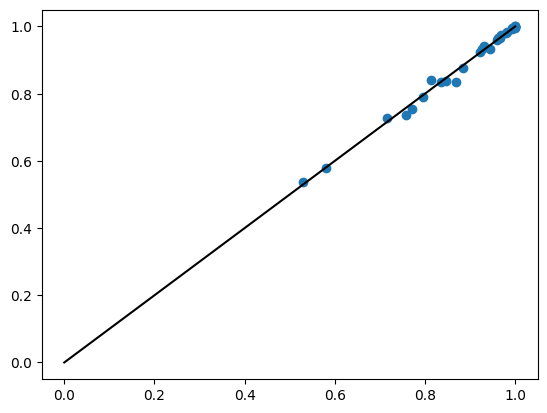

In [33]:
plt.scatter(replicate_df.values[:, 0], replicate_df.values[:, 1]);
plt.plot([0, 1], [0, 1], 'k');

In [34]:
table2datasets = [
    'balance-scale',
    'mfeat-fourier',
    'mfeat-karhunen',
    'mfeat-morphological',
    'mfeat-zernike',
    'diabetes',
    'vehicle',
    'analcatdata_authorship',
    'pc4',
    'pc3',
    'kc2',
    'pc1',
    'wdbc',
    'qsar-biodeg',
    'banknote-authentication',
    'blood-transfusion-service-center',
    'steel-plates-fault',
    'climate-model-simulation-crashes',
]

In [35]:
replicate_df.mean()

me       0.895095
paper    0.894317
dtype: float64

In [36]:
replicate_df.loc[table2datasets].mean()

me       0.934366
paper    0.933528
dtype: float64